In [1]:
import sys
sys.path.append("../")  # go to parent directory

from src.utils import read_csv, get_sentiment_mapping
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Map predictions to sentiment labels
label_mapping_reverse = get_sentiment_mapping(sent_list=SENT_LABELS)
label_mapping_reverse

{0: 'Irrelevant', 1: 'Neutral', 2: 'Negative', 3: 'Positive'}

In [4]:
col_names =  ['id','entity','labels','text']
unseen_df = read_csv(path=PATH_TO_DATA, col_names=col_names)
unseen_df.head(5)

,id,entity,labels,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [5]:
sent_labels = unseen_df['labels'].unique().tolist()
sent_labels

['Irrelevant', 'Neutral', 'Negative', 'Positive']

In [6]:
# Load the saved model and tokenizer
model_path = '../bert_model'
load_model = AutoModelForSequenceClassification.from_pretrained(model_path)
load_tokenizer = AutoTokenizer.from_pretrained(model_path, max_length=MAX_LENGTH, padding='max_length', truncation=True) 

# Ensure the model is in evaluation mode
load_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [7]:
# TextClassificationPipeline for prediction
pipe = TextClassificationPipeline(model=load_model, tokenizer=load_tokenizer, return_all_scores=True)

/home/nataliia/Workspaces/edu_private/tweets_sentiment_classification/venv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [8]:
## Single prediction to test the model
text = "Congrats to the NVIDIA NeMo team for the 1.0.0 release candidate! Really excited to see NeMo embracing Hydra as the way to take control over the configuration madness that is machine learning! :)"
prediction = pipe(text, return_all_scores=False)
print(prediction)
label = label_mapping_reverse[int(prediction[0]["label"].split("_")[1])]
print(label)

[{'label': 'LABEL_3', 'score': 0.9770637154579163}]
Positive


In [9]:
# custom function to get predictions
def get_prediction(text):
    prediction = pipe(text, top_k=1)
    label = label_mapping_reverse[int(prediction[0]["label"].split("_")[1])]
    return label

In [11]:
unseen_df['label_pred'] = unseen_df['text'].apply(lambda text: get_prediction(text))

/home/nataliia/Workspaces/edu_private/tweets_sentiment_classification/venv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [12]:
unseen_df

,id,entity,labels,text,label_pred
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,Irrelevant
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,Negative
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",Negative
4,4433,Google,Neutral,Now the President is slapping Americans in the...,Neutral
...,...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...,Neutral
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,Irrelevant
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...,Positive
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.,Positive


In [20]:
predicted_labels = unseen_df['label_pred'].values
true_labels = unseen_df['labels'].values

In [21]:
# Compute the confusion matrix
conf_mtx = confusion_matrix(true_labels, predicted_labels, labels=sent_labels)

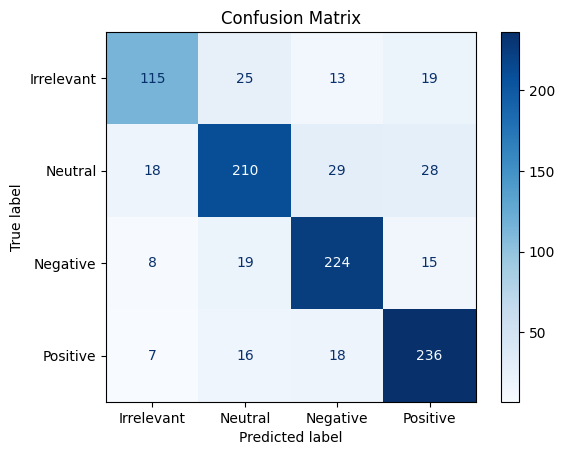

In [22]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtx, display_labels=SENT_LABELS)
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Save the results to a new CSV file
unseen_df.to_csv('../data/predicted_unseen_data.csv', index=False)

# Display the first few rows of the results
unseen_df.head()

,id,entity,labels,text,label_pred,Predicted_Sentiment
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,Irrelevant,Irrelevant
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral,Neutral
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,Negative,Negative
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",Negative,Negative
4,4433,Google,Neutral,Now the President is slapping Americans in the...,Neutral,Neutral
